In [10]:
import pickle
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import accuracy_score
import torch
from datasets_utils import single_stimuli_dataset_naming
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from CLs import Poisson_regression, Ridge_regression, Linear_regression, Softmax_multiclass, Logistic_regression_multiclass, Lasso_regression, Elastic_net_regression, SGD_regression
from CCNL_models import forwardDBN
import matplotlib.cm as cm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

def weighted_mape(y_true, y_pred):
        absolute_errors = np.abs(y_true - y_pred)
        weights = np.abs(y_true)
        wmape = np.sum(absolute_errors) / (np.sum(weights)+1e-8)
        return wmape

# Plotting function
def plot_metric(metric_by_pte, std_by_pte, title, ylabel, ylim, colormap):
    plt.figure(figsize=(12, 7.2))
    for i, (pte_label, metrics) in enumerate(metric_by_pte.items()):
        sorted_nums = sorted(metrics.keys())
        values = np.array([metrics[n] for n in sorted_nums])
        stds = np.array([std_by_pte[pte_label][n] for n in sorted_nums])
        color = colormap[pte_label]

        # Calculate average metric for legend if plotting accuracy
        legend_label = pte_label
        if ylabel.lower() == 'accuracy':
            avg_acc = np.mean(list(metrics.values()))
            legend_label = f"{pte_label} (M_acc={avg_acc:.2f})"

        plt.plot(sorted_nums, values, marker='o', color=color, label=legend_label, markersize=10, linewidth=3)
        plt.fill_between(sorted_nums, values - stds, values + stds, color=color, alpha=0.1)

    # plt.title(title)
    plt.xlabel('Numerosity', fontsize=36)
    plt.xticks(fontsize=30)
    plt.ylabel(ylabel, fontsize = 36)
    plt.yticks(fontsize=30)
    plt.ylim(*ylim)
    plt.legend( fontsize=24, title_fontsize=28)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

cuda


In [3]:
MIN_NUM = 1
MAX_NUM = 15

plots = []

train_file = f'D:/Dunja/DBN-GPU-MATLAB/datasets/NumStim_1to32_100x100_TR.mat'
test_file = f'D:/Dunja/DBN-GPU-MATLAB/datasets/NumStim_1to32_100x100_TE.mat'


LIMITS = np.array([(MIN_NUM-1),MAX_NUM,41])
PERCENTAGES = np.array([0, 100,0])


In [11]:
# Datasets for the estimation task
try:
    train_contents = scipy.io.loadmat(train_file)
    N_list_train = train_contents['N_list']
except NotImplementedError:
    with h5py.File(train_file, 'r') as mat_file:
        N_list_train = mat_file['N_list'][()]


unique_N = np.unique(N_list_train)
print(f"Unique numerosity values: {unique_N}")
print(f'Number of unique numerosities: {len(unique_N)}')

distributed_percentages = {n: 0 for n in unique_N}

for i in range(len(LIMITS)-1):
    lower, upper = LIMITS[i], LIMITS[i + 1]
    mask = (unique_N > lower) & (unique_N <= upper)
    count = np.sum(mask)
    if count > 0:
        for idx in np.where(mask)[0]:
            distributed_percentages[unique_N[idx]] = PERCENTAGES[i + 1] / count

print(distributed_percentages)

datasets = []

samples_per_num = 1500
limit_FAs = [
False
             ]
limit_circle_r =45

for limit_FA in limit_FAs:
    # Create new single stimuli datasets
    train_dataset = single_stimuli_dataset_naming(train_file, num_samples=samples_per_num*MAX_NUM, num_percentage_dict=distributed_percentages, limit_FA=limit_FA, limit_radius = limit_circle_r)
    test_dataset = single_stimuli_dataset_naming(test_file, num_samples=samples_per_num*MAX_NUM, num_percentage_dict=distributed_percentages, limit_FA=limit_FA, limit_radius= limit_circle_r) 

    print("Train dataset data shape:", train_dataset['data'].shape)
    print("Train dataset labels shape:", train_dataset['labels'].shape)
    print("Train dataset idxs shape:", train_dataset['idxs'].shape)

    ##############################################################
    # And save the dataset
    # output_path_tr = 'D:/Dunja/Sep2024/DeWind/new/datasets/single_stimuli_naming_1_15_TR.pkl'
    # output_path_te = 'D:/Dunja/Sep2024/DeWind/new/datasets/single_stimuli_naming_1_15_TE.pkl'

    # with open(output_path_tr, 'wb') as f:
    #     pickle.dump(train_dataset, f)

    # with open(output_path_te, 'wb') as f:
        # pickle.dump(test_dataset, f)


    #############################################################
    # OR load a preexisting single stimuli dataset

    # train_dataset = pickle.load(open('D:/Dunja/Sep2024/DeWind/new/datasets/single_stimuli_naming_1_15_TR.pkl', 'rb'))
    # test_dataset = pickle.load(open('D:/Dunja/Sep2024/DeWind/new/datasets/single_stimuli_naming_1_15_TE.pkl', 'rb'))

    datasets.append({
                                'FA_limit': limit_FA,
                                'train_dataset': train_dataset,
                                'test_dataset': test_dataset,
                            })

Unique numerosity values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]
Number of unique numerosities: 32
{1.0: 6.666666666666667, 2.0: 6.666666666666667, 3.0: 6.666666666666667, 4.0: 6.666666666666667, 5.0: 6.666666666666667, 6.0: 6.666666666666667, 7.0: 6.666666666666667, 8.0: 6.666666666666667, 9.0: 6.666666666666667, 10.0: 6.666666666666667, 11.0: 6.666666666666667, 12.0: 6.666666666666667, 13.0: 6.666666666666667, 14.0: 6.666666666666667, 15.0: 6.666666666666667, 16.0: 0.0, 17.0: 0.0, 18.0: 0.0, 19.0: 0.0, 20.0: 0.0, 21.0: 0.0, 22.0: 0.0, 23.0: 0.0, 24.0: 0.0, 25.0: 0.0, 26.0: 0.0, 27.0: 0.0, 28.0: 0.0, 29.0: 0.0, 30.0: 0.0, 31.0: 0.0, 32.0: 0.0}
D shape: (10000, 81120)
(38025,)
max number of samples: 38025
number of samples: 22500
Unique numerosities: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]
D shape: (10000,

In [12]:
distributions = ['zipfian', 'uniform']

pretrain_E = [0]
training_E = [200]
reint = [0]
runs = 1

# Training the classifiers
dbn_training_numrange = '1to40'

results = []
predictions = []

layer_sizes = [
    [500, 500], 
    [500, 1000], [500, 1500], [500, 2000], 
    [1000, 500], [1000, 1000], [1000, 1500], 
    [1500, 500], [1500, 1500], [1500, 2000], 
    [1500, 1000],
      [1000, 2000]
]

classifiers = [
    # Ridge_regression,
    SGD_regression
]

for distribution in distributions:
    print(f"\n================  Distribution: {distribution}  ================\n")
    for dataset in datasets:
        print(f"\n======  FA_limit = {dataset['FA_limit']}  ======\n")

        train_dataset = dataset['train_dataset']
        test_dataset = dataset['test_dataset']

        for run in range(1, runs + 1):
            for ri in reint:
                for pte in pretrain_E:
                    for te in training_E:
                        # Generate DBN path dynamically
                        dbn_path = f'D:/Dunja/Sep2024/NEW/idbns_SEP25/{distribution}/idbn_{distribution}_TE{te}_R{run}'

                        for classifier in classifiers:
                            print(f'\n================  {classifier.__name__}  ================\n')
                            for layer_size in layer_sizes:
                                input_path = f"{dbn_path}_{layer_size[0]}_{layer_size[1]}.pkl"  # NEW TRAINING
                                
                                with open(input_path, 'rb') as f:
                                    dbn = pickle.load(f)

                                XtrainComp, YtrainComp, idxs_train = train_dataset['data'].to(DEVICE), train_dataset['labels'].to(DEVICE), train_dataset['idxs'].to(DEVICE)
                                XtestComp, YtestComp, idxs_test = test_dataset['data'].to(DEVICE), test_dataset['labels'].to(DEVICE), test_dataset['idxs'].to(DEVICE)

                                _XtrainComp = forwardDBN(dbn, XtrainComp).clone()
                                _XtestComp = forwardDBN(dbn, XtestComp).clone()

                                accTR, predTR, predTR_logs, probTR, accTE, choice, choice_log, probTE = classifier(
                                    _XtrainComp, _XtestComp, YtrainComp, YtestComp,
                                    labels='log', last_layer_size=layer_size[1],
                                    MAX_NUM=MAX_NUM, scale=0
                                )

                                Y_test = YtestComp.cpu().numpy().ravel()
                                y_pred = choice
                                wmape = weighted_mape(Y_test, y_pred)

                                print(f"\nTest Accuracy: {accTE:.4f}")
                                print(f"WMAPE: {wmape:.4f}")

                                results.append({
                                    'alg': dbn_path,
                                    'RI': ri,
                                    'TE': te,
                                    'PTE': pte,
                                    'classifier': classifier.__name__,
                                    'Layer Size': f"{layer_size[0]} {layer_size[1]}",
                                    "Accuracy": accTE,
                                    'WMAPE': wmape,
                                    'FA_limit': dataset['FA_limit'],
                                    'run': run,
                                    'distribution': distribution
                                })

                                predictions.append({
                                    'alg': dbn_path,
                                    'RI': ri,
                                    'TE': te,
                                    'PTE': pte,
                                    'classifier': classifier.__name__,
                                    'Layer Size': f"{layer_size[0]} {layer_size[1]}",
                                    "Accuracy": accTE,
                                    'WMAPE': wmape,
                                    'FA_limit': dataset['FA_limit'],
                                    'run': run,
                                    'Y_test': Y_test,
                                    'y_pred': y_pred,
                                    'choice': choice,
                                    'choice_log': choice_log,
                                    'distribution': distribution
                                })

results_df = pd.DataFrame(results)
output_file = f'D:/Dunja/Sep2024/NEW/results/estimation_results_SEP25.xlsx'


================  Distribution: zipfian  ================


======  FA_limit = False  ======


================  SGD_regression  ================


Test Accuracy: 0.2997
WMAPE: 0.1567

Test Accuracy: 0.3621
WMAPE: 0.1334

Test Accuracy: 0.3823
WMAPE: 0.1289

Test Accuracy: 0.3857
WMAPE: 0.1291

Test Accuracy: 0.3099
WMAPE: 0.1461

Test Accuracy: 0.3540
WMAPE: 0.1292

Test Accuracy: 0.3940
WMAPE: 0.1180

Test Accuracy: 0.2988
WMAPE: 0.1490

Test Accuracy: 0.3932
WMAPE: 0.1152

Test Accuracy: 0.3929
WMAPE: 0.1170

Test Accuracy: 0.3464
WMAPE: 0.1307

Test Accuracy: 0.3939
WMAPE: 0.1182

================  Distribution: uniform  ================


======  FA_limit = False  ======


================  SGD_regression  ================


Test Accuracy: 0.3402
WMAPE: 0.1439

Test Accuracy: 0.3473
WMAPE: 0.1429

Test Accuracy: 0.3669
WMAPE: 0.1413

Test Accuracy: 0.3652
WMAPE: 0.1376

Test Accuracy: 0.3521
WMAPE: 0.1391

Test Accuracy: 0.4153
WMAPE: 0.1142

Test Accuracy: 0.4071
WMAPE: 0.1125



In [17]:
numeric_columns = results_df.select_dtypes(include='number').columns

summary = (
    results_df
    .groupby('distribution')[numeric_columns]
    .agg(['mean', 'std'])   # calculate both mean and std
    .reset_index()
    .sort_values(('Accuracy', 'mean'))  # sort by mean Accuracy
)

print(summary)

  distribution   RI          TE       PTE       Accuracy               WMAPE  \
               mean  std   mean  std mean  std      mean       std      mean   
1      zipfian  0.0  0.0  200.0  0.0  0.0  0.0  0.359389  0.037843  0.130949   
0      uniform  0.0  0.0  200.0  0.0  0.0  0.0  0.378030  0.031254  0.127919   

             run       
        std mean  std  
1  0.013518  1.0  0.0  
0  0.014960  1.0  0.0  


C:\Users\CCNL\AppData\Local\Temp\ipykernel_14508\1834505867.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', n_dist)


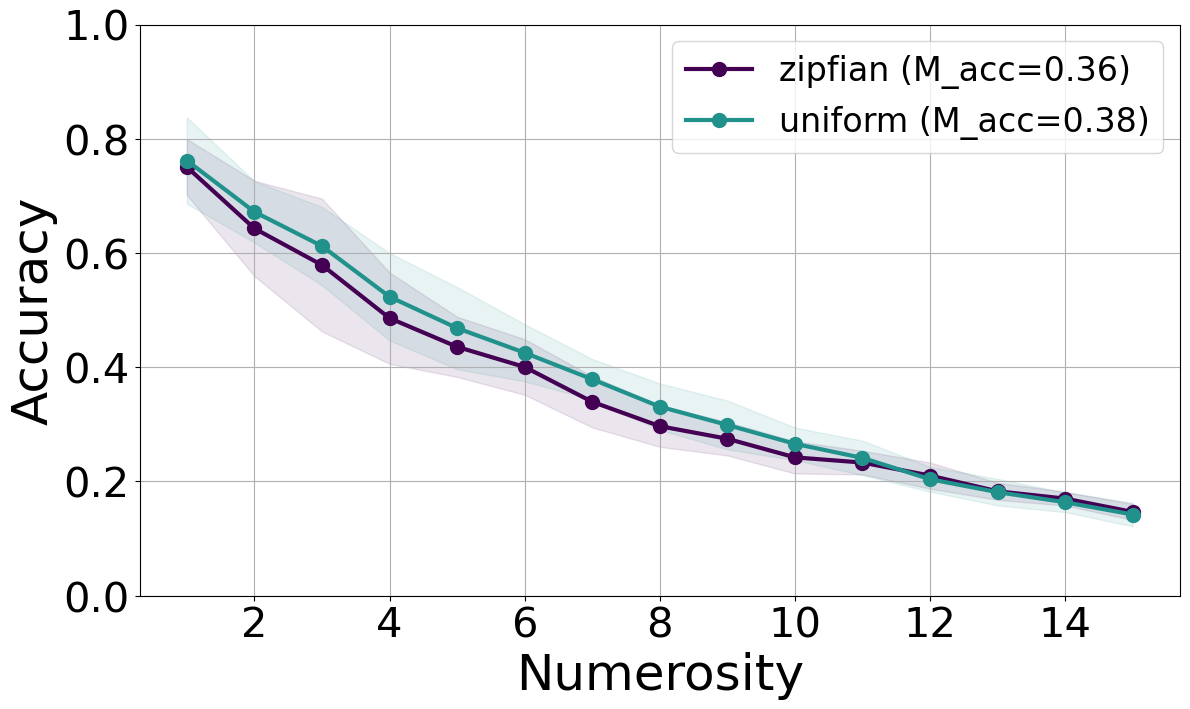

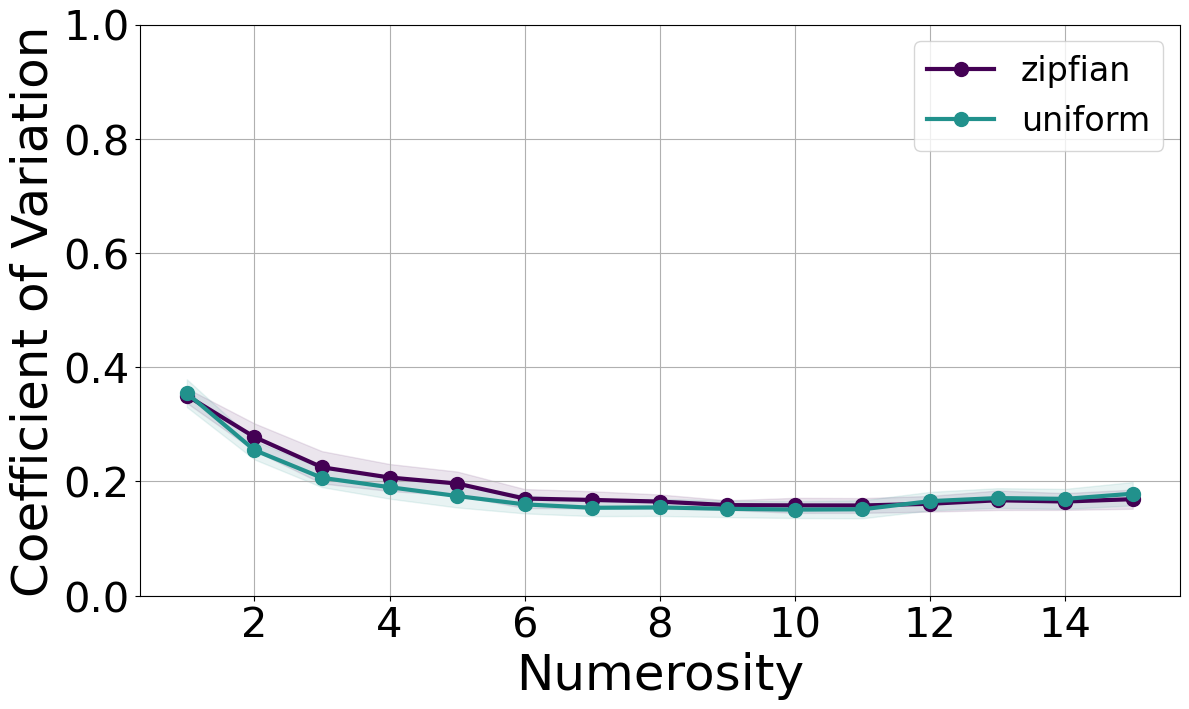

In [13]:
# Initialize nested dictionaries
accuracy_by_dist = {}
wmape_by_dist = {}
cov_by_dist = {}

# Loop through all predictions
for pred in predictions:
    Ytest_flat = pred['Y_test']
    choice = pred['choice']
    distribution = pred['distribution']  # using distribution now

    if distribution not in accuracy_by_dist:
        accuracy_by_dist[distribution] = {}
        wmape_by_dist[distribution] = {}
        cov_by_dist[distribution] = {}

    unique_classes = np.unique(Ytest_flat)
    for cls in unique_classes:
        class_mask = (Ytest_flat == cls)

        # Accuracy
        acc = accuracy_score(Ytest_flat[class_mask], choice[class_mask])
        accuracy_by_dist[distribution].setdefault(cls, []).append(acc)

        # WMAPE
        wmape = weighted_mape(Ytest_flat[class_mask], choice[class_mask])
        wmape_by_dist[distribution].setdefault(cls, []).append(wmape)

        # Coefficient of Variation
        preds = choice[class_mask]
        cov = np.std(preds) / np.mean(preds) if np.mean(preds) != 0 else 0
        cov_by_dist[distribution].setdefault(cls, []).append(cov)

# Compute averages per distribution and numerosity
avg_accuracy_by_dist = {
    dist: {cls: np.mean(vals) for cls, vals in cls_vals.items()}
    for dist, cls_vals in accuracy_by_dist.items()
}
avg_wmape_by_dist = {
    dist: {cls: np.mean(vals) for cls, vals in cls_vals.items()}
    for dist, cls_vals in wmape_by_dist.items()
}
avg_cov_by_dist = {
    dist: {cls: np.mean(vals) for cls, vals in cls_vals.items()}
    for dist, cls_vals in cov_by_dist.items()
}

# Compute standard deviations per distribution and numerosity
std_accuracy_by_dist = {
    dist: {cls: np.std(vals) for cls, vals in cls_vals.items()}
    for dist, cls_vals in accuracy_by_dist.items()
}
std_wmape_by_dist = {
    dist: {cls: np.std(vals) for cls, vals in cls_vals.items()}
    for dist, cls_vals in wmape_by_dist.items()
}
std_cov_by_dist = {
    dist: {cls: np.std(vals) for cls, vals in cls_vals.items()}
    for dist, cls_vals in cov_by_dist.items()
}


# Automatically assign colors using a colormap
dist_labels = list(avg_accuracy_by_dist.keys())
n_dist = len(dist_labels)
colormap = cm.get_cmap('tab10', n_dist)
colors = plt.cm.viridis(np.linspace(0, 1, 3))
dist_color_map = dict(zip(dist_labels, colors))

# Plot metrics
plot_metric(avg_accuracy_by_dist, std_accuracy_by_dist, 'Average Accuracy per Numerosity', 'Accuracy', (0, 1), dist_color_map)
# plot_metric(avg_wmape_by_dist, std_wmape_by_dist, 'Average WMAPE per Numerosity', 'WMAPE', (0, 0.5), colors)
plot_metric(avg_cov_by_dist, std_cov_by_dist, 'Average Coefficient of Variation per Numerosity', 'Coefficient of Variation', (0, 1), dist_color_map)



Layer Size: 500 500

SGD_regression with  zipfian distribution:



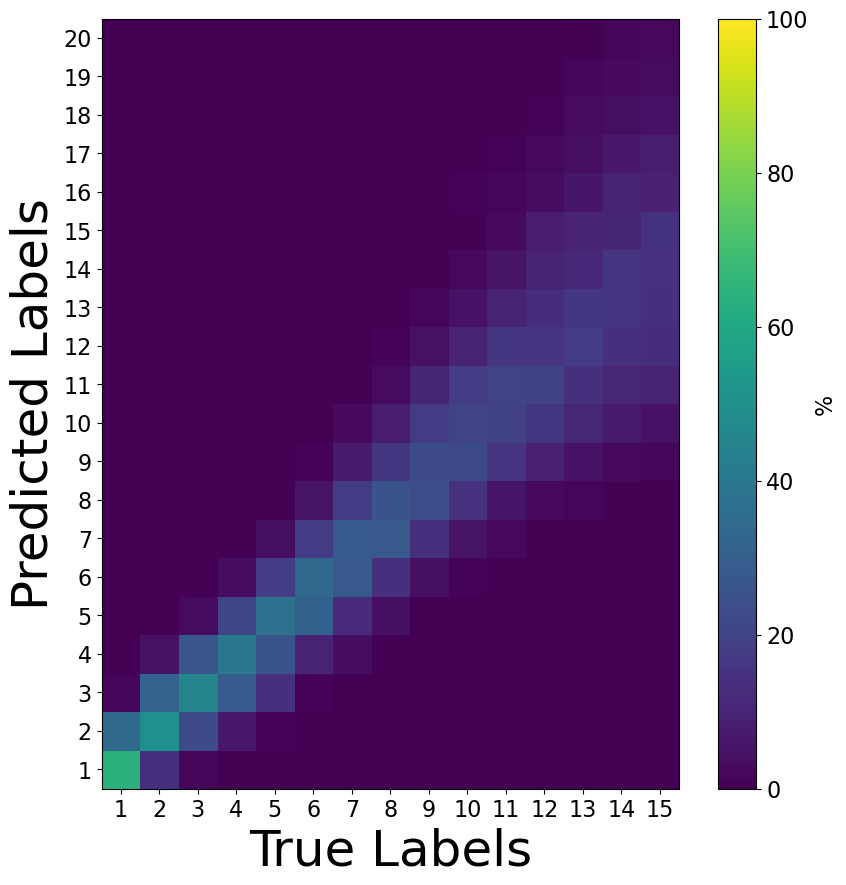


Layer Size: 500 1000

SGD_regression with  zipfian distribution:



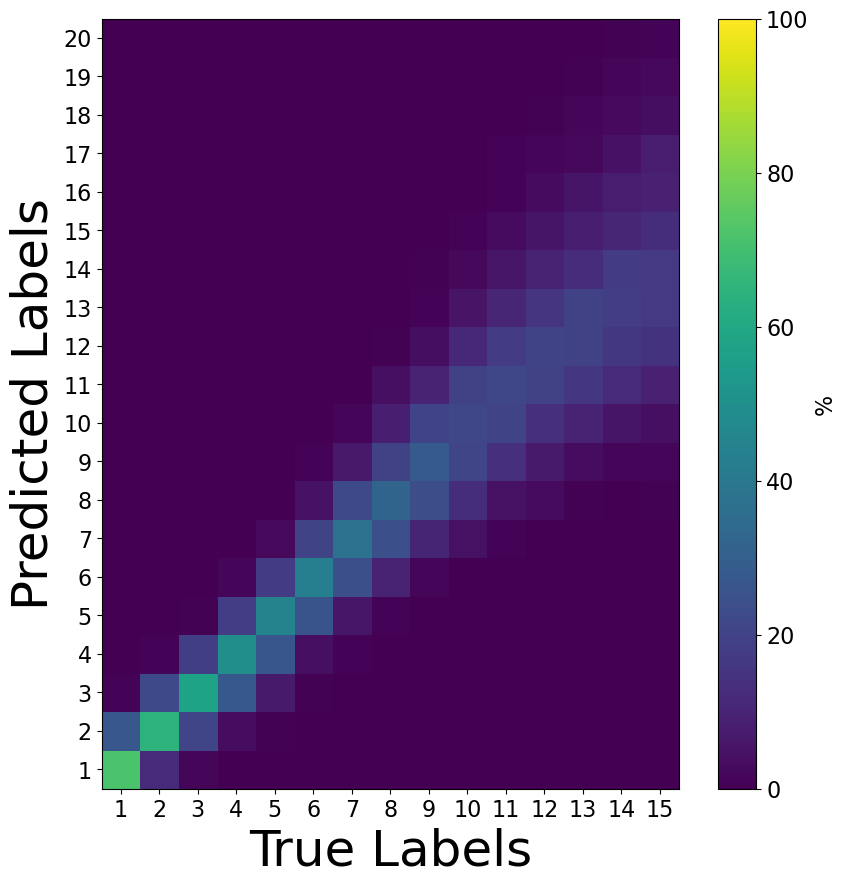


Layer Size: 500 1500

SGD_regression with  zipfian distribution:



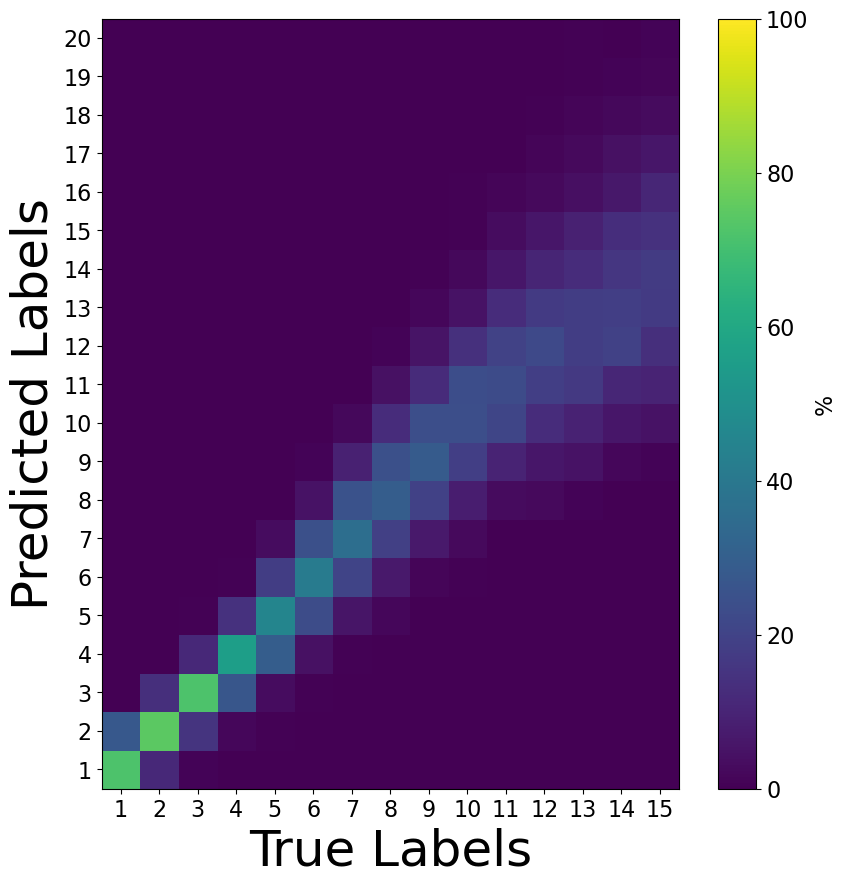


Layer Size: 500 2000

SGD_regression with  zipfian distribution:



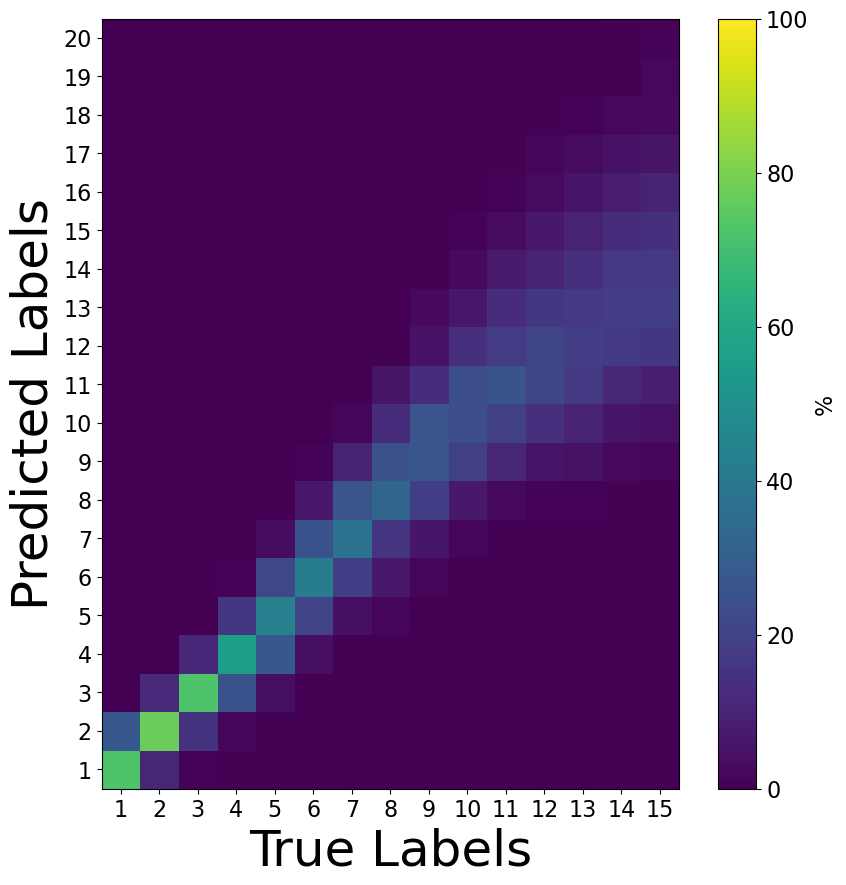


Layer Size: 1000 500

SGD_regression with  zipfian distribution:



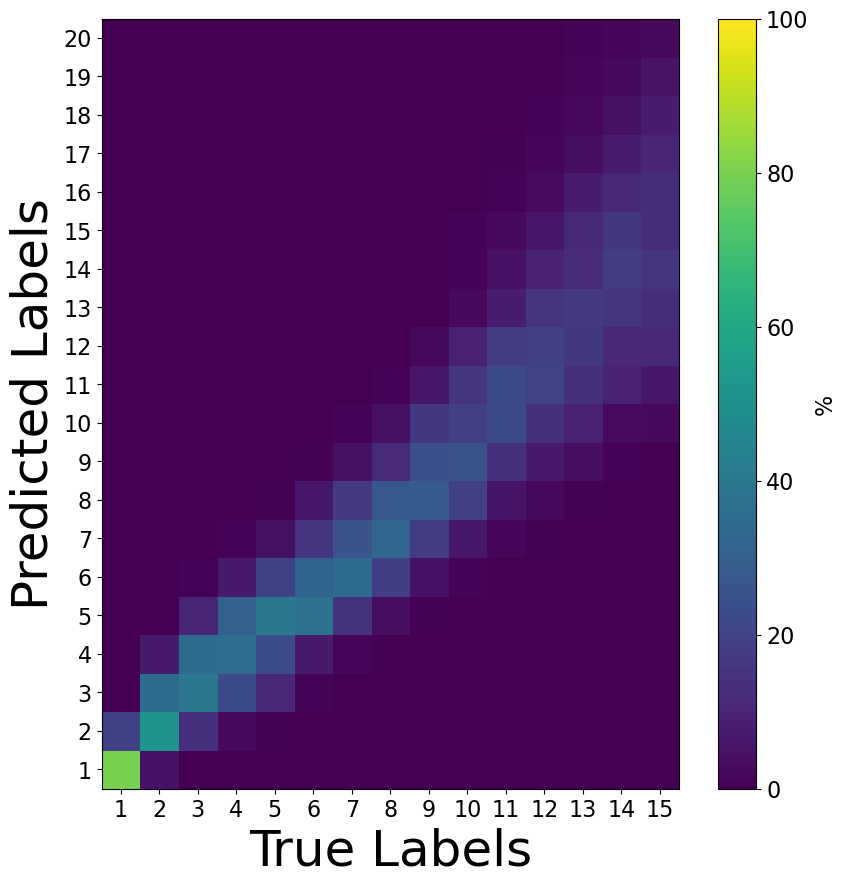


Layer Size: 1000 1000

SGD_regression with  zipfian distribution:



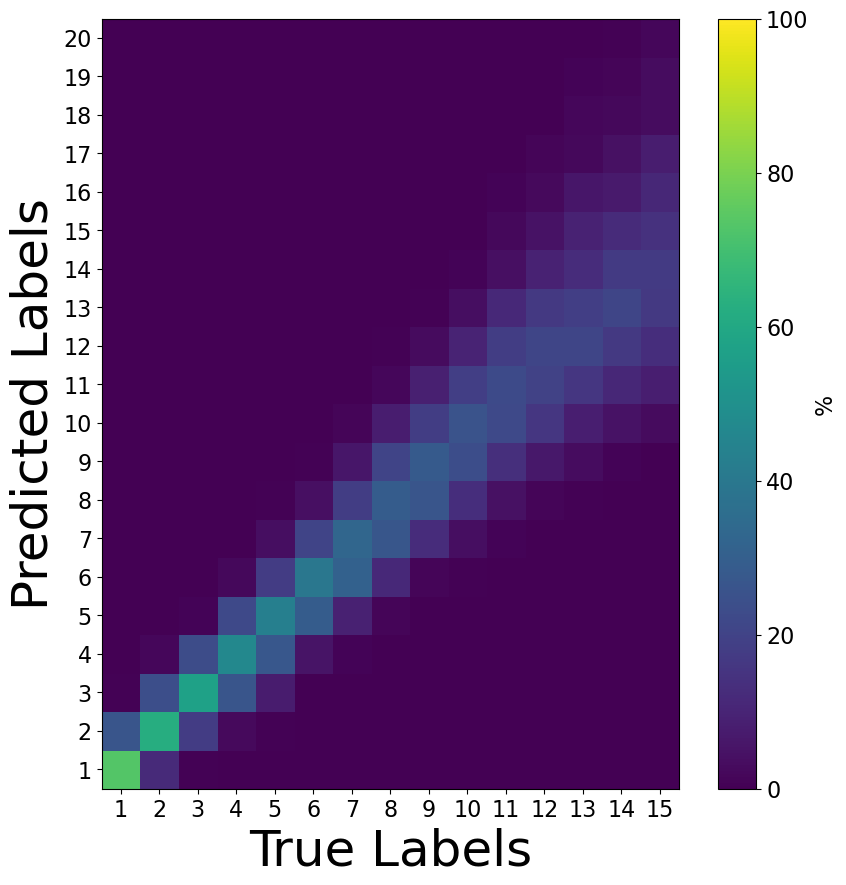


Layer Size: 1000 1500

SGD_regression with  zipfian distribution:



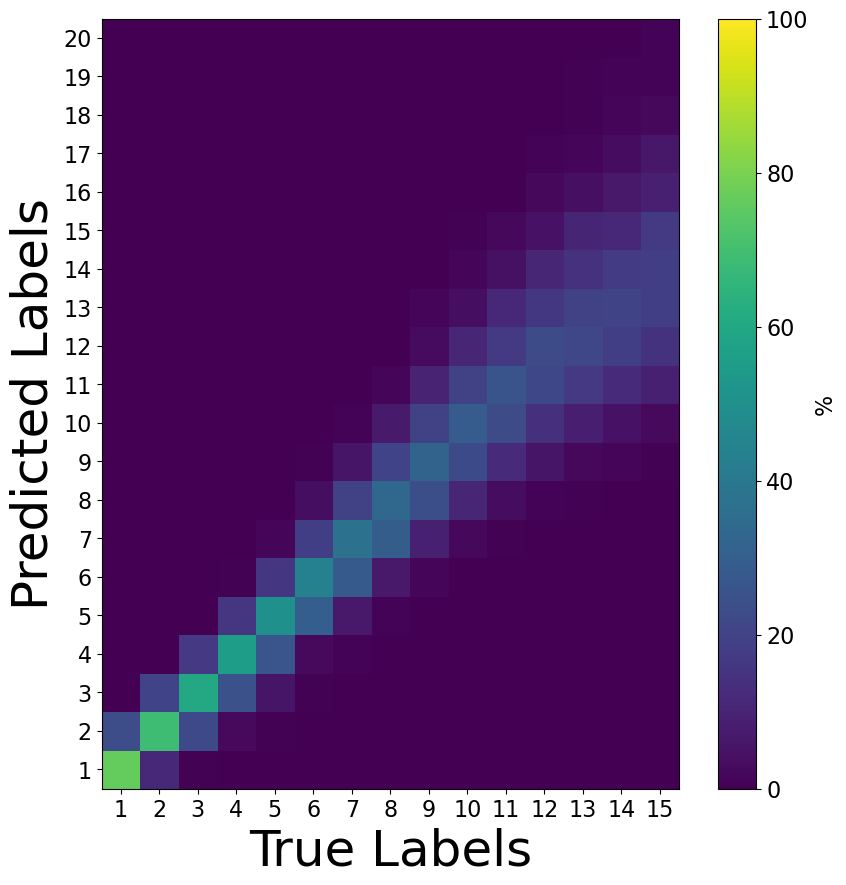


Layer Size: 1500 500

SGD_regression with  zipfian distribution:



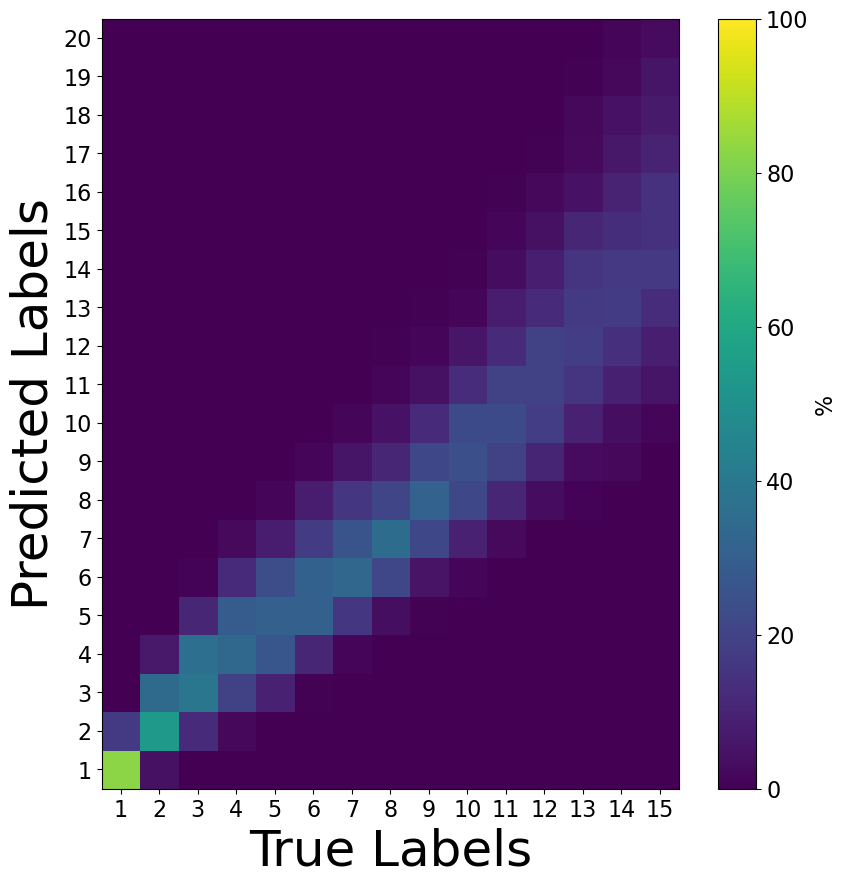


Layer Size: 1500 1500

SGD_regression with  zipfian distribution:



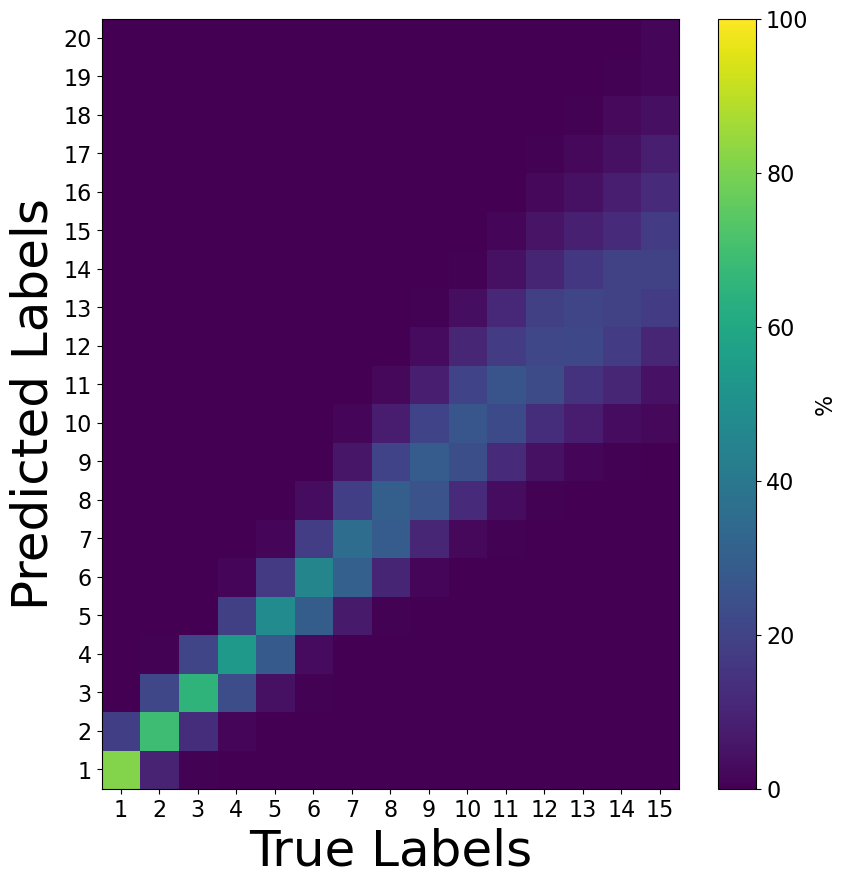


Layer Size: 1500 2000

SGD_regression with  zipfian distribution:



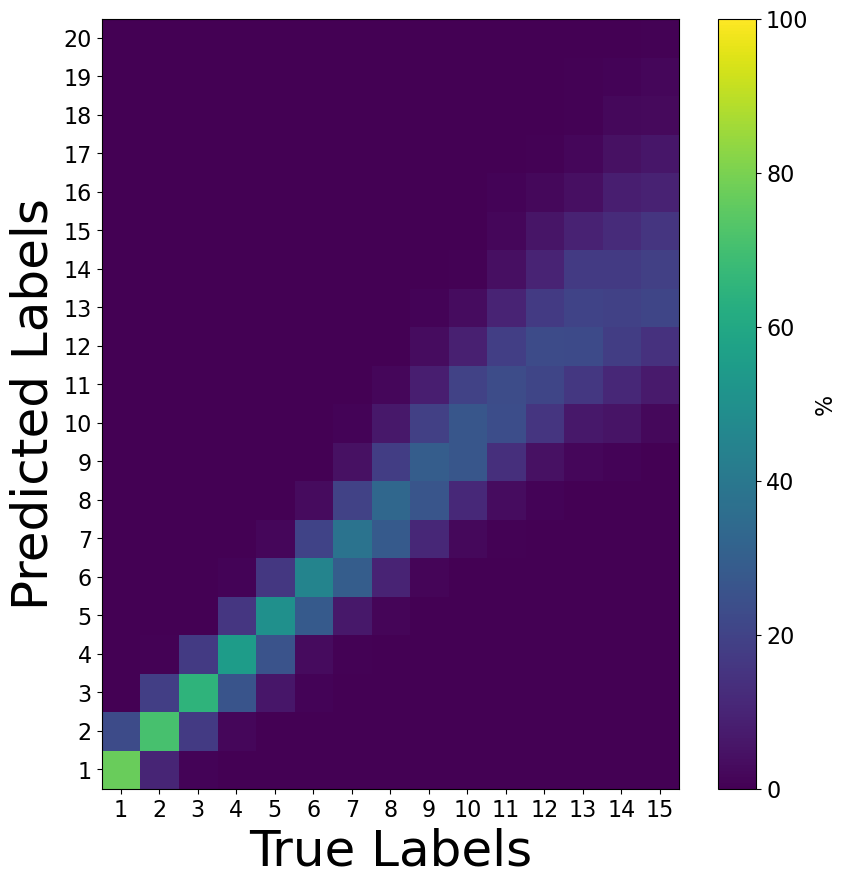


Layer Size: 1500 1000

SGD_regression with  zipfian distribution:



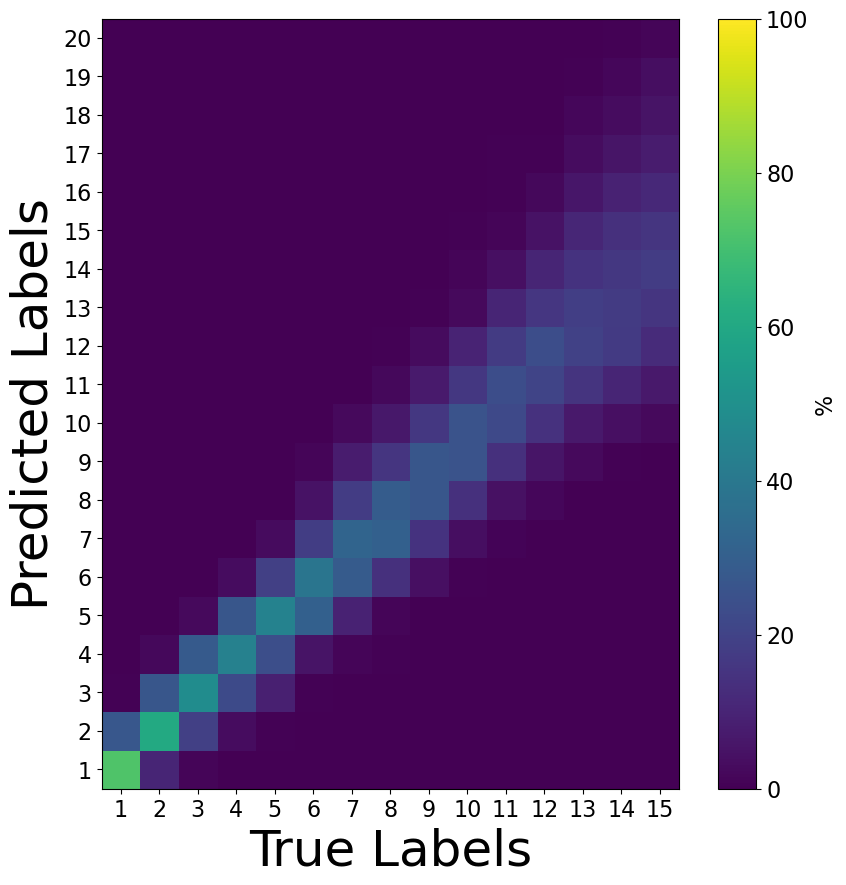


Layer Size: 1000 2000

SGD_regression with  zipfian distribution:



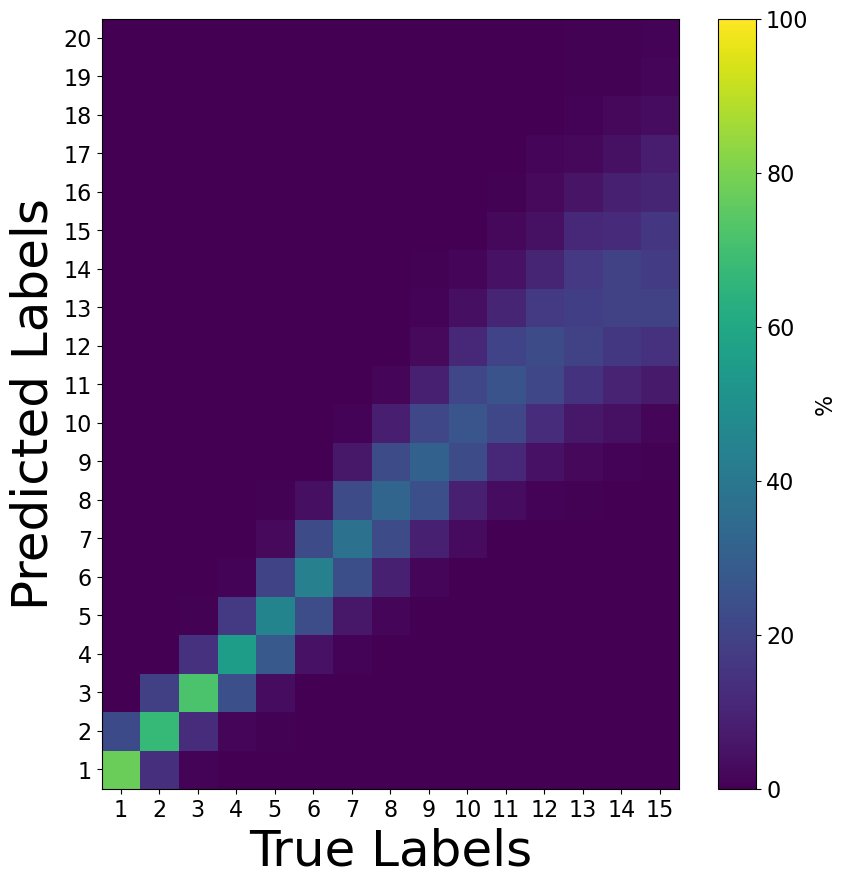


Layer Size: 500 500

SGD_regression with  uniform distribution:



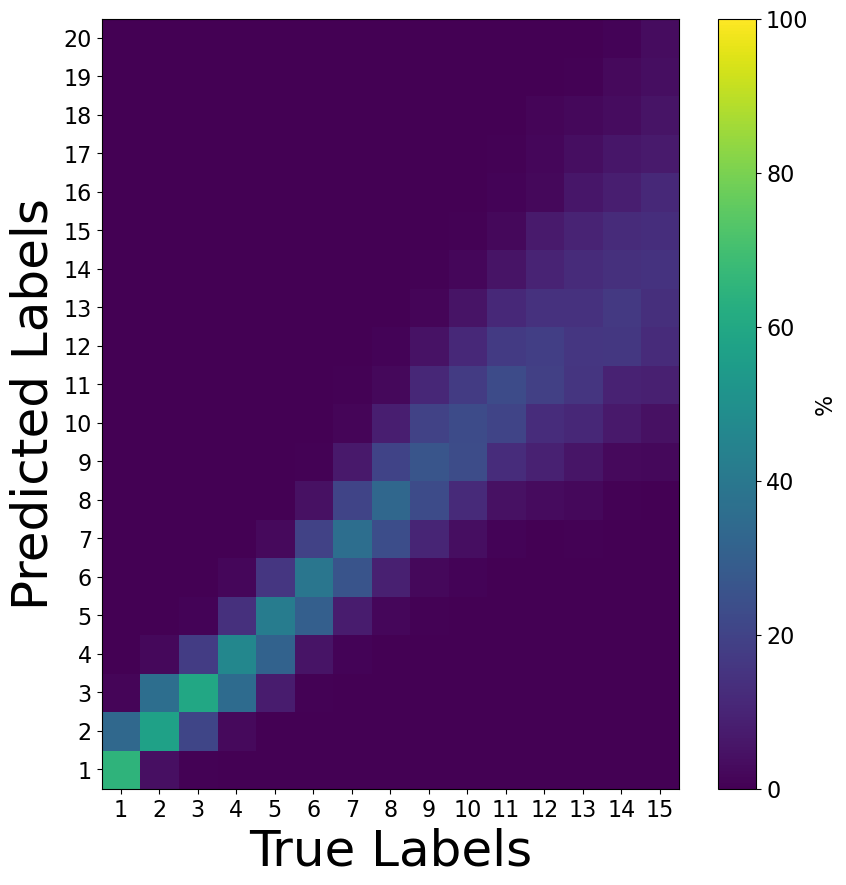


Layer Size: 500 1000

SGD_regression with  uniform distribution:



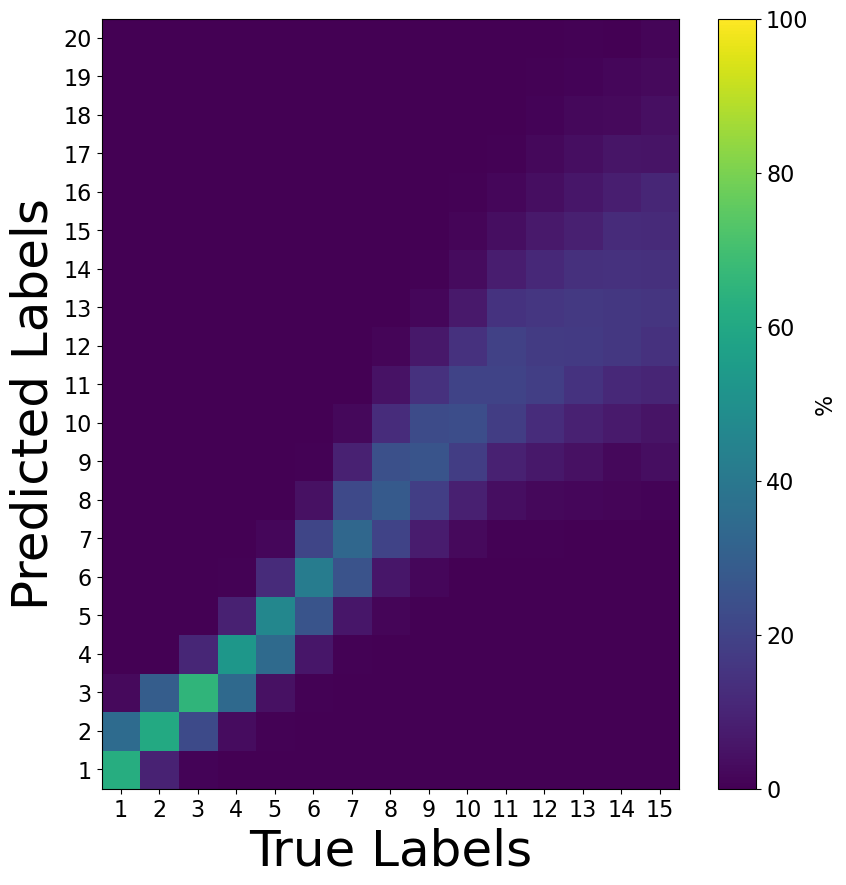


Layer Size: 500 1500

SGD_regression with  uniform distribution:



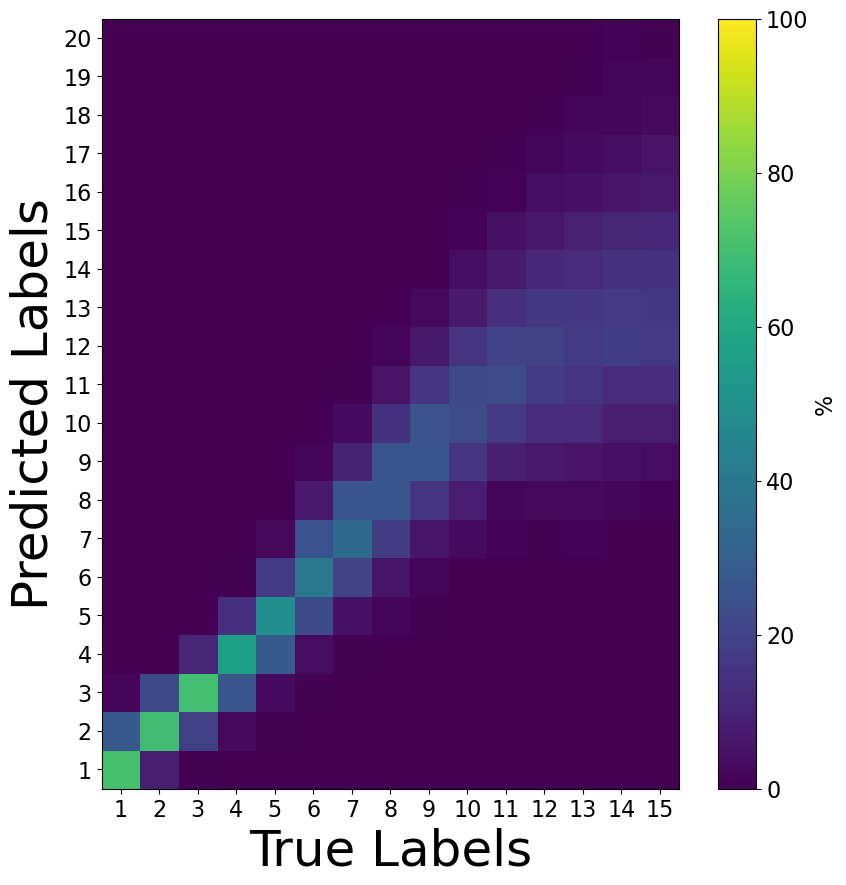


Layer Size: 500 2000

SGD_regression with  uniform distribution:



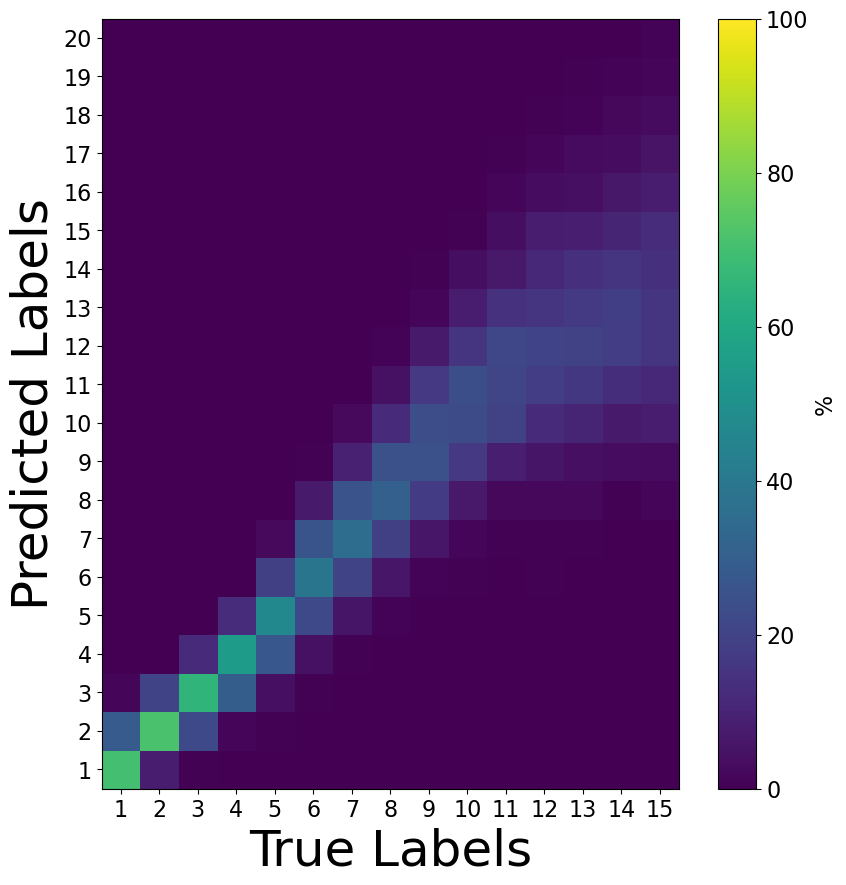


Layer Size: 1000 500

SGD_regression with  uniform distribution:



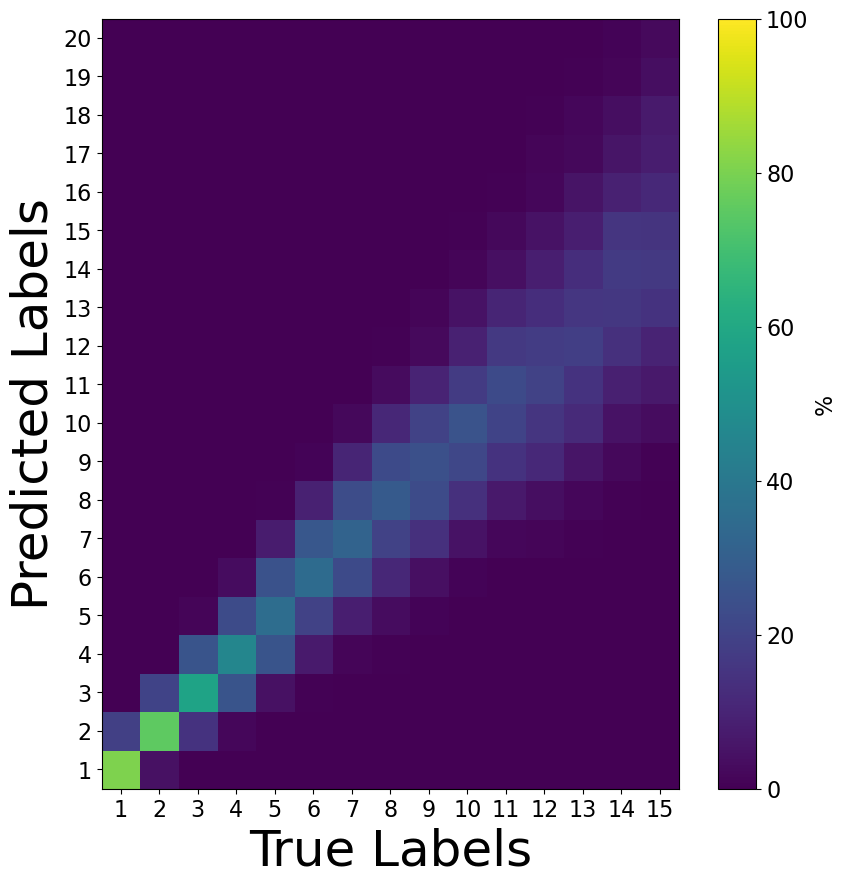


Layer Size: 1000 1000

SGD_regression with  uniform distribution:



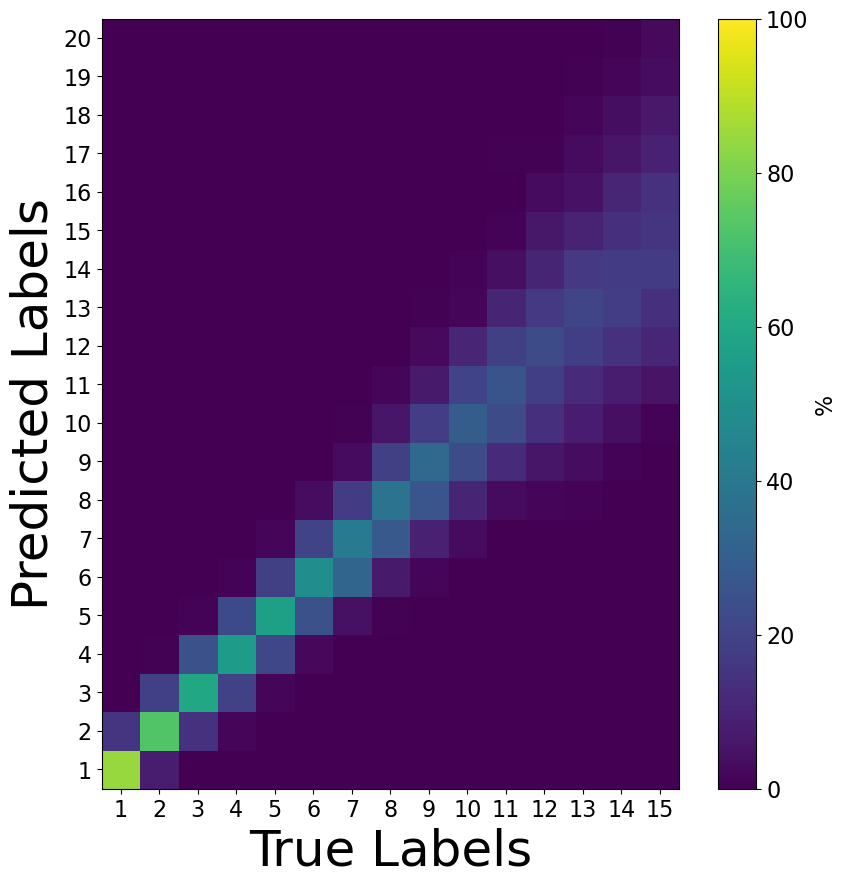


Layer Size: 1000 1500

SGD_regression with  uniform distribution:



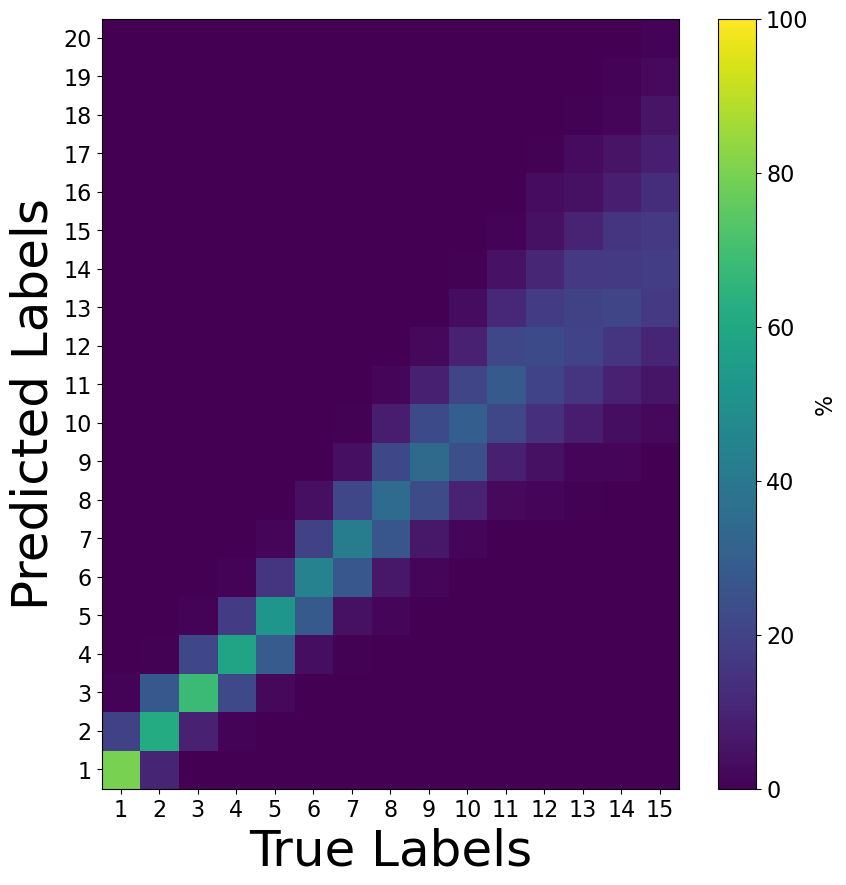


Layer Size: 1500 500

SGD_regression with  uniform distribution:



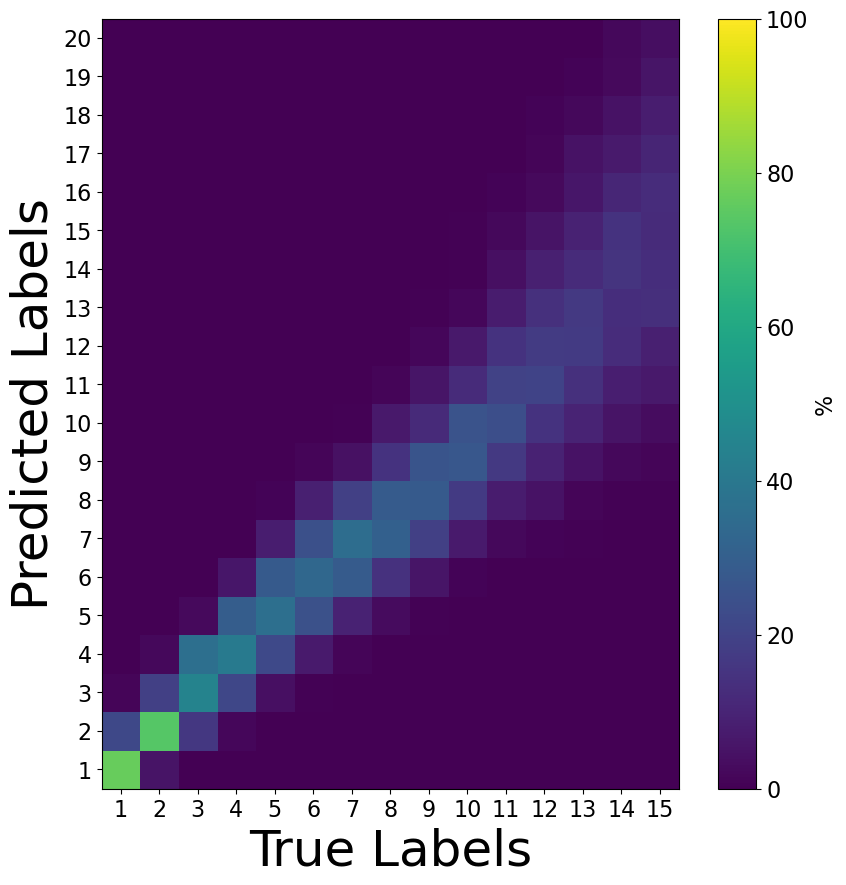


Layer Size: 1500 1500

SGD_regression with  uniform distribution:



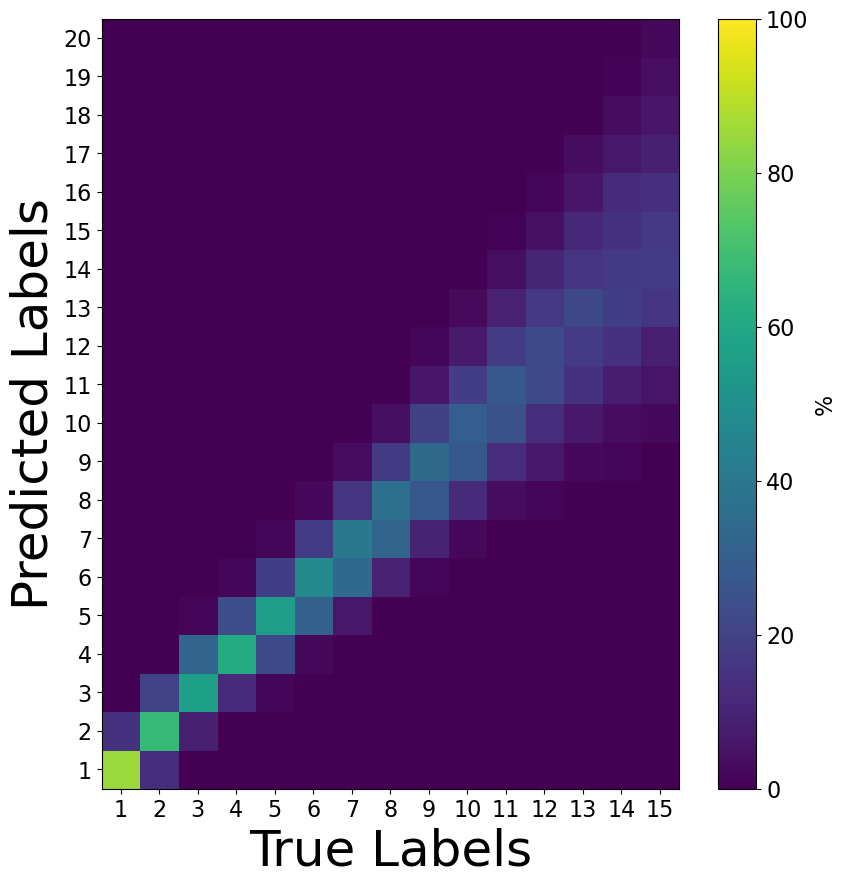


Layer Size: 1500 2000

SGD_regression with  uniform distribution:



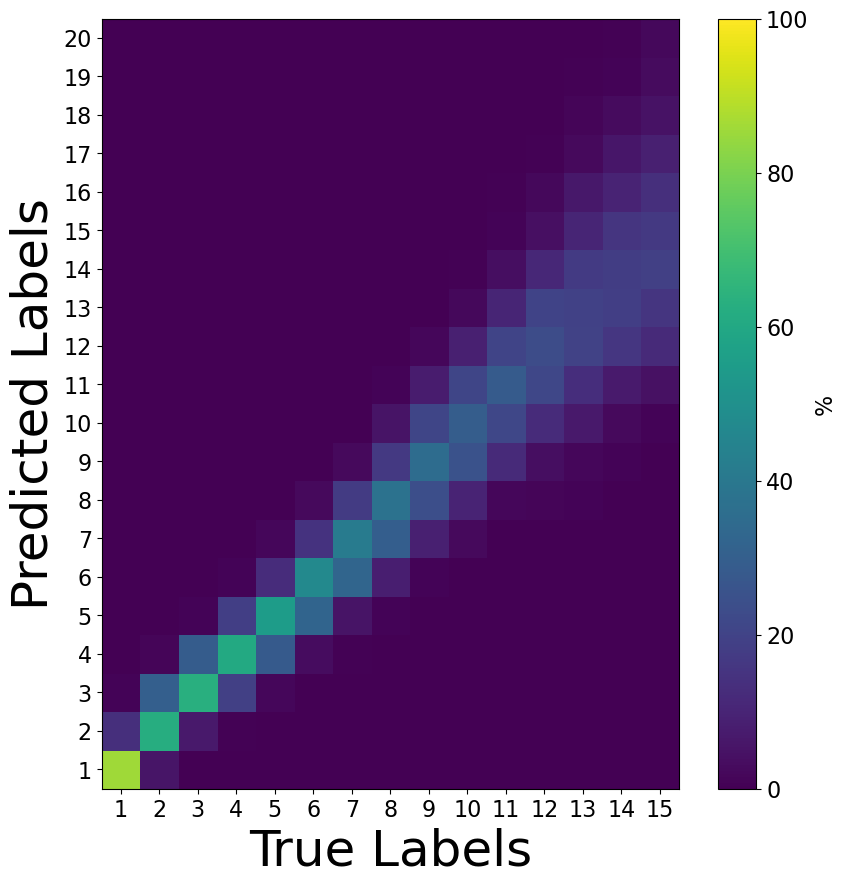


Layer Size: 1500 1000

SGD_regression with  uniform distribution:



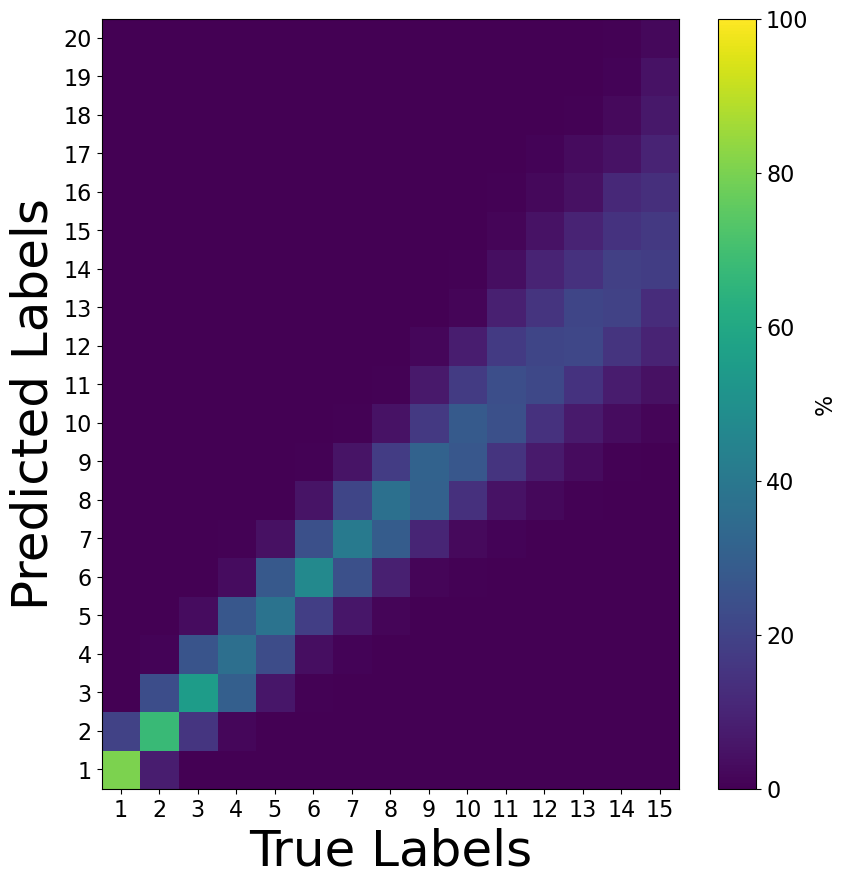


Layer Size: 1000 2000

SGD_regression with  uniform distribution:



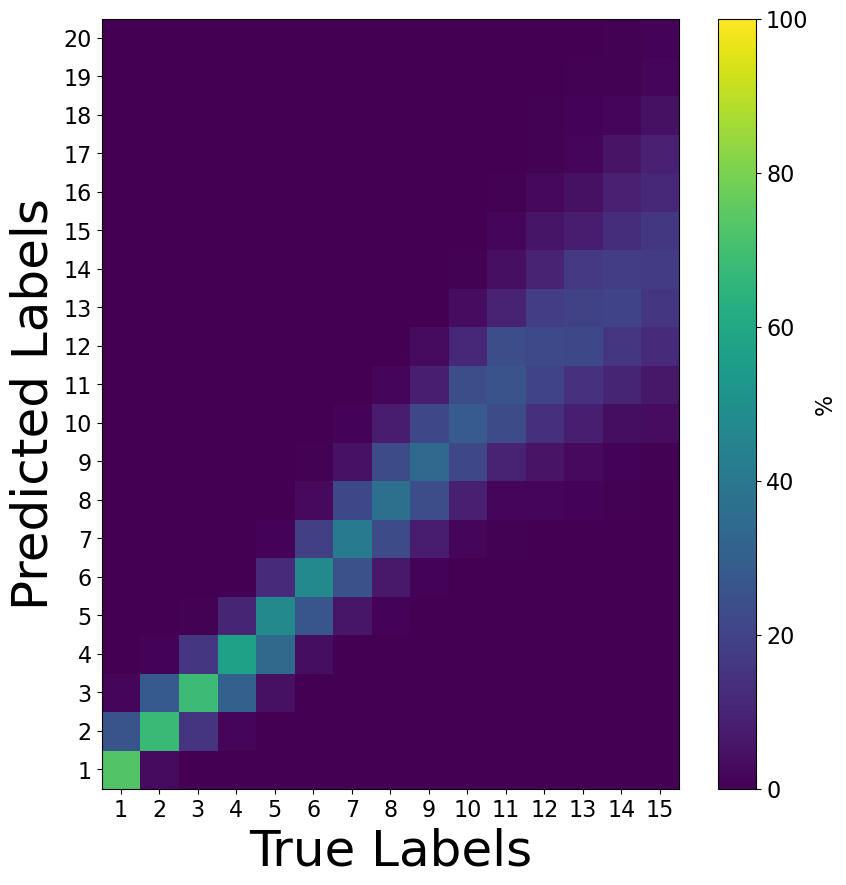

In [16]:
# Plotting confusion matrices
confusion_matrices = []

for prediction in predictions:
    layer_size = prediction['Layer Size']
    print(f"\nLayer Size: {layer_size}")
    choice = prediction['choice']
    Y_test = prediction['Y_test']
    distribution = prediction['distribution']
    print(f"\n{prediction['classifier']} with  {distribution} distribution:\n")
    y_pred = choice

    unique_Y = np.unique(Y_test)
    unique_pred = np.unique(y_pred)
    all_unique_labels = np.unique(np.concatenate((Y_test, choice)))

    wmape = weighted_mape(Y_test, y_pred)

    cm = confusion_matrix(Y_test, choice, labels=all_unique_labels)

    # Get indices of true labels in the full label set
    true_label_indices = [np.where(all_unique_labels == label)[0][0] for label in unique_Y]

    # Filter the confusion matrix to include only rows for true labels
    filtered_cm = cm[true_label_indices, :]

    # Limit to 20 rows
    filtered_cm = filtered_cm[:, :20]
    filtered_labels = unique_Y[:20]
    filtered_predicitons =  unique_pred[:20]

    cm_percentage = filtered_cm.astype('float') / filtered_cm.sum(axis=1, keepdims=True) * 100

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm_percentage.T, interpolation='nearest', cmap=plt.cm.viridis)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_label('%', fontsize=16)

    ax.set_xticks(np.arange(len(filtered_labels)))
    ax.set_xticklabels(filtered_labels)
    ax.set_yticks(np.arange(len(filtered_predicitons)))
    ax.set_yticklabels(filtered_predicitons)
    cbar.ax.tick_params(labelsize=16)

    im.set_clim(0, 100)

    # plt.title(f"{prediction['classifier']}\n", loc='left')
    plt.xlabel("True Labels", fontsize =36)
    plt.ylabel("Predicted Labels", fontsize =36)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().invert_yaxis()
    plt.show()

    confusion_matrices.append({
        'cm': filtered_cm,
        'classifier': prediction['classifier'],
        'FA_limit': prediction['FA_limit']
    })
